# Testing the two-level asymptotic form of `Whirl2d`

In [29]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body undergoing an oscillatory translation in `x` direction

In [30]:
Npts = 100
rad = 0.5
xcent = [0.0,0.0]
ang = 0.0
b = Bodies.Circle(Npts,rad,xcent,ang)
Bodies.set_velocity!(b,(t,xi)->[cos(t),0.0],1)
Bodies.set_velocity!(b,(t,xi)->[0.0,0.0],2)

2-element Array{Function,1}:
 #35
 #37

### Create a domain with this body in it

In [31]:
xmin = [-1.0,-1.0]
xmax = [1.0,1.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b)

Domain: xmin = [-1.0, -1.0], xmax = [1.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [32]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [1.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Grid: number of cells = (100,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [1.0, 1.0]



### Set the physical and time parameters

In [33]:
Re = 40
physparams = NavierStokes.set_freestream([0.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)

(Whirl2d.NavierStokes.PhysParams([0.0, 0.0], 40.0), 0.625)

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [34]:
@time ops = NavierStokes.set_operators_two_level_body!(dom,params);
A⁻¹,L⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂ = ops

  4.796083 seconds (38.12 M allocations: 2.552 GiB, 6.18% gc time)


(Whirl2d.NavierStokes.A⁻¹, Whirl2d.NavierStokes.L⁻¹, Whirl2d.NavierStokes.B₁ᵀ, Whirl2d.NavierStokes.B₂!, Whirl2d.NavierStokes.S⁻¹, Whirl2d.NavierStokes.S₀⁻¹, Whirl2d.NavierStokes.r₁, Whirl2d.NavierStokes.r₂)

### Create an initial solution structure

In [35]:
s = NavierStokes.TwoLevelBodySoln(dom)

Solution: t = 0.0


### Advance the solution

In [48]:
@time for i = 1:20
    s = TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)
end
s.ψ = -L⁻¹(s.u)

  2.734277 seconds (28.50 M allocations: 1.983 GiB, 13.19% gc time)


2-element Array{Array{Float64,2},1}:
 [-9.00051 -8.99856 … 8.9601 8.9549; -9.1838 -9.18563 … 9.13969 9.13073; … ; -8.82097 -8.81548 … 8.78404 8.78238; -8.64502 -8.63619 … 8.61136 8.61305]   
 [1.22251 1.24707 … -1.19859 -1.17406; 1.24735 1.27348 … -1.22195 -1.19598; … ; -1.19818 -1.22125 … 1.17568 1.15252; -1.17342 -1.19506 … 1.15229 1.13046]

### Plot the solution

#### Level 1 solution

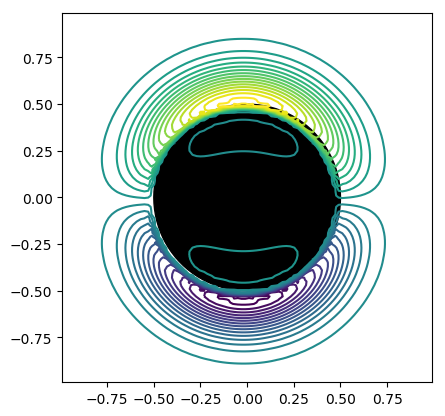

(-0.99, 0.99, -0.99, 0.99)

In [49]:
x = [dom.grid.xmin[1]+Δx*(i-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
y = [dom.grid.xmin[2]+Δx*(j-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]

contour(x,y,s.u[1][dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

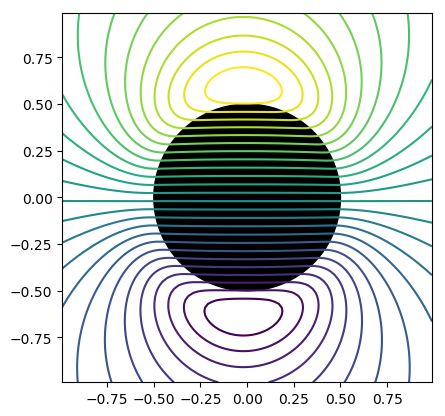

(-0.99, 0.99, -0.99, 0.99)

In [50]:
contour(x,y,s.ψ[1][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx,31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

#### Level 2 solution

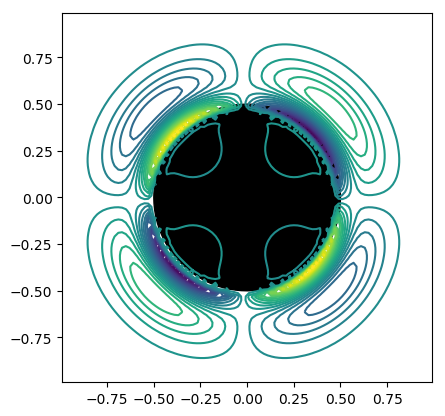

(-0.99, 0.99, -0.99, 0.99)

In [51]:
x = [dom.grid.xmin[1]+Δx*(i-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
y = [dom.grid.xmin[2]+Δx*(j-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]

contour(x,y,s.u[2][dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

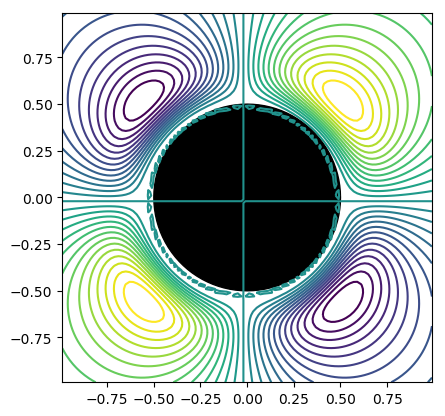

(-0.99, 0.99, -0.99, 0.99)

In [52]:
contour(x,y,s.ψ[2][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx,31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")